In [1]:
import sys, os, glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
# from libs.activations import lrelu
import math
import numpy as np
import random as rnd

In [2]:
def get_autoencoder(batch_size):
    
    g = tf.Graph()
    with g.as_default():

        # %%
        # define parameters for input sizes and filters for autoencoder layers
        input_shape = [batch_size, 40, 320, 1]
        n_filters = [1, 10]
        filter_sizes = [[8, 10]]
        strides_i = [[4, 5]]

        # %%
        # input to the network
        x = tf.placeholder(tf.float32, input_shape, name='x')

        # %%
        # ensure input is 4-d.
        if len(x.get_shape()) == 4:
            x_tensor = x
        else:
            raise ValueError('Unsupported input dimensions')
        current_input = x_tensor

        # %%
        # Build the encoder
        encoder = []
        shapes = []
        for layer_i, n_output in enumerate(n_filters[1:]):
            n_input = current_input.get_shape().as_list()[3]
            shapes.append(current_input.get_shape().as_list())
            W = tf.Variable(
                tf.random_uniform([filter_sizes[layer_i][0], filter_sizes[layer_i][1], n_input, n_output],
                    -1.0 / math.sqrt(filter_sizes[layer_i][0]*filter_sizes[layer_i][1]*n_input),
                     1.0 / math.sqrt(filter_sizes[layer_i][0]*filter_sizes[layer_i][1]*n_input)))
            encoder.append(W)
            b = tf.Variable(tf.zeros([n_output]))
            output = tf.nn.relu(tf.add(tf.nn.conv2d(current_input, W, strides=[1, strides_i[layer_i][0], strides_i[layer_i][1], 1], padding='VALID'), b))
            print('layer ', layer_i, 'has output shape =', output.get_shape())
            current_input = output

        # %%
        # the latent representation
        z = current_input
        z_shape = z.get_shape()
        print('z.shape =', z_shape) #, 'beta =', beta)

        encoder.reverse()
        shapes.reverse()
        strides_i.reverse()

        # %%
        # Build the decoder using the same weights
        for layer_i, shape in enumerate(shapes):
            W = encoder[layer_i]
            b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
            output = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(current_input, W, tf.stack([x.get_shape()[0], shape[1], shape[2], shape[3]]),
                    strides=[1, strides_i[layer_i][0], strides_i[layer_i][1], 1], padding='VALID'), b))
            print('layer ', layer_i, 'has output shape =', output.get_shape())
            current_input = output

        # %%
        # the reconstruction through the network
        y = current_input
        # cost function measures pixel-wise difference
        cost = tf.reduce_sum(tf.square(y - x_tensor))
        
        l2_regularizer = tf.contrib.layers.l2_regularizer(scale=200.0, scope=None)
#         weights = tf.trainable_variables()
        l2_cost = tf.contrib.layers.apply_regularization(l2_regularizer, [W])
        
        cost_t = cost + l2_cost

        # %%
        # define the optimizer
        # Head_weights, Head_bias, z_head_out_weights, z_head_out_bias
        # Place_weights, Place_bias, z_place_out_weights, z_place_out_bias
        learning_rate = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_t)
        
        # %%
        # dict for inputs, outputs, and costs
        ae = {'x': x, 'z': z, 'y': y, 'cost': cost, 'l2_cost': l2_cost, 'cost_t': cost_t, 'optimizer':optimizer}
        
        return g, ae

In [3]:
# %%
# load training image
train_images = np.load('train_images.npy')
print(type(train_images), train_images.shape)
# mean_img = np.mean(train_images, axis=0)
# print('mean_img.shape =', mean_img.shape)
# plt.figure()
# plt.imshow(mean_img[:, :, 0], cmap='gray')

# load training cmd
train_cmds = np.load("train_cmds.npy")
print(type(train_cmds), train_cmds.shape)
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
print(train_steps.shape, train_angles.shape)

# load training image2
train_images2 = np.load('train_images2.npy')
print(type(train_images2), train_images2.shape)
# mean_img2 = np.mean(train_images2, axis=0)
# print('mean_img2.shape =', mean_img2.shape)
# plt.figure()
# plt.imshow(mean_img2[:, :, 0], cmap='gray')

# load training cmd2
train_cmds2 = np.load("train_cmds2.npy")
print(type(train_cmds2), train_cmds2.shape)
train_steps2 = train_cmds2[:, 0]
train_angles2 = train_cmds2[:, 1]
print(train_steps2.shape, train_angles2.shape)

<class 'numpy.ndarray'> (40000, 40, 320, 1)
<class 'numpy.ndarray'> (39999, 3)
(39999,) (39999,)
<class 'numpy.ndarray'> (40000, 40, 320, 1)
<class 'numpy.ndarray'> (39999, 3)
(39999,) (39999,)


In [40]:
saved_model = 'modelxxx2'

# %%
# Fit training data
example_num = 40
tf.reset_default_graph()
g, ae = get_autoencoder(example_num)
with g.as_default():
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={ae['x']: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={ae['x']: train})
                print(epoch_i, ':', batch_i, ':1:cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={ae['x']: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={ae['x']: train})
                print(epoch_i, ':', batch_i, ':2:cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

layer  0 has output shape = (40, 9, 63, 10)
z.shape = (40, 9, 63, 10)
layer  0 has output shape = (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx2
0 : 0 :1:cost = 1600.94 l2_cost = 544.0 cost_t = 2144.94
0 : 1000 :1:cost = 1263.91 l2_cost = 513.486 cost_t = 1777.39
0 : 2000 :1:cost = 1696.03 l2_cost = 527.643 cost_t = 2223.68
0 : 3000 :1:cost = 1345.61 l2_cost = 562.172 cost_t = 1907.78
0 : 4000 :1:cost = 1502.17 l2_cost = 546.004 cost_t = 2048.18
0 : 5000 :1:cost = 1519.51 l2_cost = 556.574 cost_t = 2076.09
0 : 6000 :1:cost = 1353.89 l2_cost = 536.655 cost_t = 1890.54
0 : 7000 :1:cost = 1267.19 l2_cost = 517.821 cost_t = 1785.01
0 : 8000 :1:cost = 1719.77 l2_cost = 573.169 cost_t = 2292.94
0 : 9000 :1:cost = 1550.2 l2_cost = 555.609 cost_t = 2105.81
0 : 10000 :1:cost = 1321.98 l2_cost = 535.485 cost_t = 1857.47
0 : 11000 :1:cost = 1518.88 l2_cost = 563.052 cost_t = 2081.93
0 : 12000 :1:cost = 1204.14 l2_cost = 525.978 cost_t = 1730.12
0 : 13000 :1:cost = 1297

1 : 9000 :2:cost = 1244.95 l2_cost = 578.025 cost_t = 1822.97
1 : 10000 :2:cost = 1453.95 l2_cost = 573.089 cost_t = 2027.04
1 : 11000 :2:cost = 1309.37 l2_cost = 542.938 cost_t = 1852.31
1 : 12000 :2:cost = 1278.24 l2_cost = 525.59 cost_t = 1803.83
1 : 13000 :2:cost = 1312.32 l2_cost = 560.199 cost_t = 1872.52
1 : 14000 :2:cost = 1204.03 l2_cost = 568.461 cost_t = 1772.5
1 : 15000 :2:cost = 1147.11 l2_cost = 513.725 cost_t = 1660.84
1 : 16000 :2:cost = 1397.98 l2_cost = 545.798 cost_t = 1943.77
1 : 17000 :2:cost = 1410.67 l2_cost = 536.868 cost_t = 1947.54
1 : 18000 :2:cost = 1459.72 l2_cost = 556.321 cost_t = 2016.04
1 : 19000 :2:cost = 1341.31 l2_cost = 554.385 cost_t = 1895.69
1 : 20000 :2:cost = 1402.05 l2_cost = 571.494 cost_t = 1973.54
1 : 21000 :2:cost = 1188.95 l2_cost = 577.296 cost_t = 1766.24
1 : 22000 :2:cost = 1244.63 l2_cost = 554.125 cost_t = 1798.75
1 : 23000 :2:cost = 1307.22 l2_cost = 527.108 cost_t = 1834.32
1 : 24000 :2:cost = 1498.42 l2_cost = 590.302 cost_t = 208

layer  0 has output shape = (4, 9, 63, 10)
z.shape = (4, 9, 63, 10)
layer  0 has output shape = (4, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx2
[ 0.  0.  0.] [ 10.  10.  10.]
[ 0.  0.  0.] [-10. -10. -10.]
(8, 40, 320, 1) (8, 40, 320, 1)


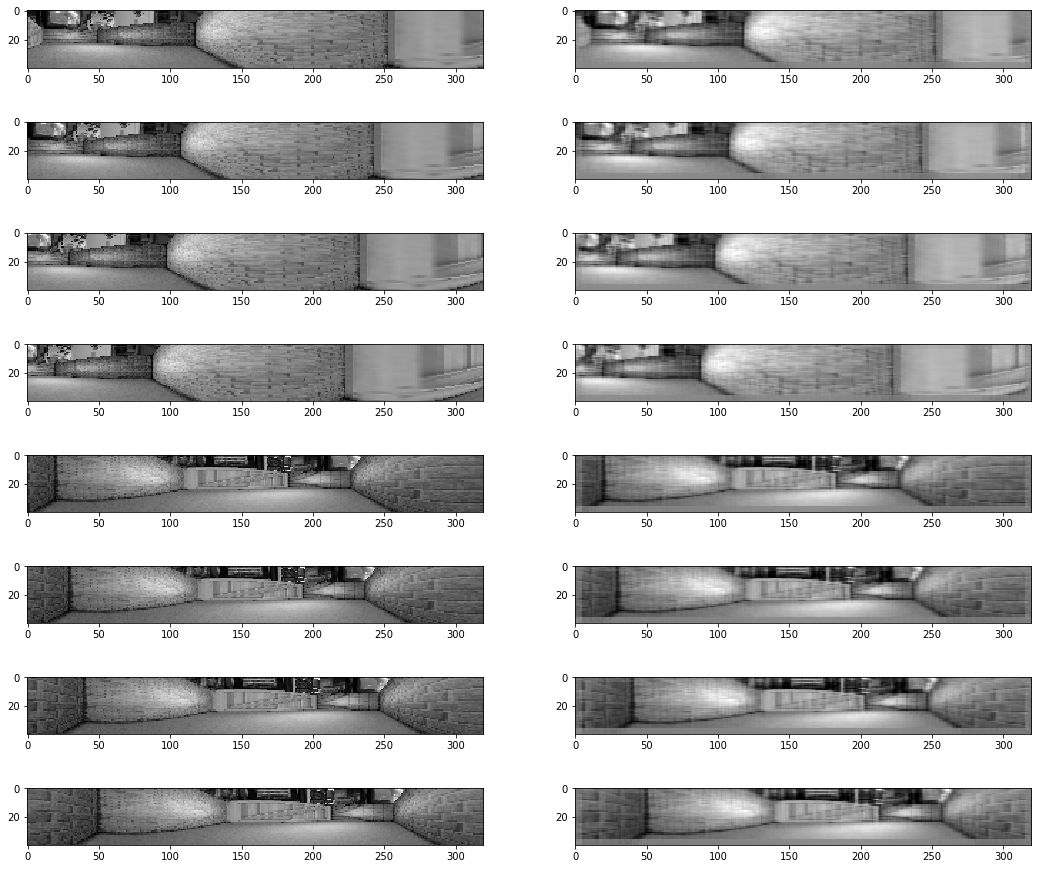

In [41]:
# %%
# Plot reconstruction example
example_num = 4
tf.reset_default_graph()
g, ae = get_autoencoder(example_num)
with g.as_default():
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img for img in test_xs])
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img2 for img in test_xs2])
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon2 = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})

    test_xs = np.concatenate((test_xs, test_xs2), axis=0)
    recon = np.concatenate((recon, recon2), axis=0)
    print(test_xs.shape, recon.shape)
    fig, axs = plt.subplots(example_num*2, 2, figsize=(18, 4*example_num))
    for example_i in range(example_num*2):
        axs[example_i][0].imshow(test_xs[example_i, :, :, 0], cmap='gray')
        if example_i < example_num/2:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
        else:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img2[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
    plt.show()

In [18]:
# %%
# Plot activation of neurons
example_num = 40
saved_model = 'modelxxx2'

tf.reset_default_graph()
g, ae = get_autoencoder(example_num)
with g.as_default():
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print(steps_test, angles_test)
    z1 = sess.run(ae['z'], feed_dict={ae['x']: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print(steps_test, angles_test)
    z2 = sess.run(ae['z'], feed_dict={ae['x']: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

layer  0 has output shape = (40, 9, 63, 10)
z.shape = (40, 9, 63, 10)
layer  0 has output shape = (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx2
[ 0.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.] [-10.   0.   0.   0.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.   0.   0.   0.   0. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10.]
[ 0.  0.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  2.  0.  0.  0.  0.  0.  0.  0.  2.  2.  0.  0.
  0.  0.  0.] [-10. -10.   0.   0.   0. -10. -10. -10. -10. -10. -10. -10. -10.   0.   0.
  10.  10.  10.  10.  10.  10.  10.  10.   0.   0.  10.  10.  10.  10.  10.
  10.  10.   0.   0.  10.  10.  10.  10.  10.]
z1.shape = (40, 9, 63, 10)
z2.shape = (40, 9, 63, 10)


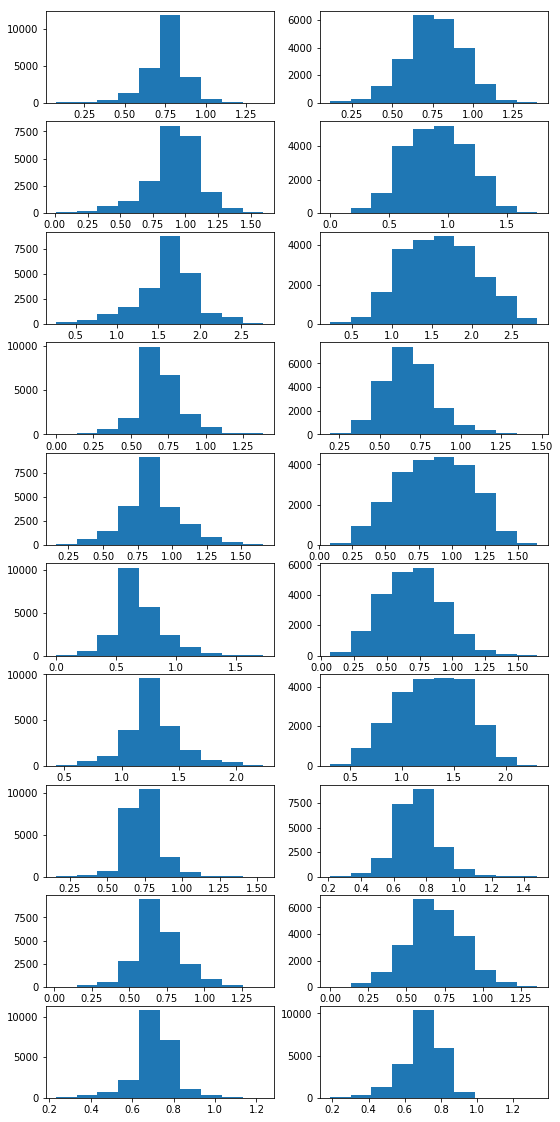

In [19]:
tmp1 = np.reshape(z1, (40*9*63, 10))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (40*9*63, 10))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

### Get the pretained weights

layer  0 has output shape = (4, 9, 63, 10)
z.shape = (4, 9, 63, 10)
layer  0 has output shape = (4, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx2
w1.shape =  (8, 10, 1, 10)
b1.shape =  (10,)
w1_val.shape = (8, 10, 1, 10)


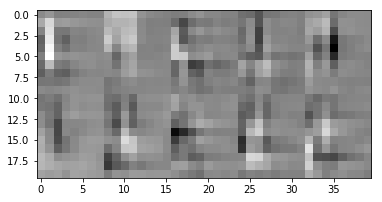

In [42]:
example_num = 4
tf.reset_default_graph()
g, ae = get_autoencoder(example_num)
with g.as_default():
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    variables_list = tf.trainable_variables()
    for v in variables_list:
#         print(v)
        if v.name == 'Variable:0':
            w1 = v.eval(sess)
            print('w1.shape = ', w1.shape)
            np.save('model/w1.npy', w1)
        if v.name == 'Variable_1:0':
            b1 = v.eval(sess)
            print('b1.shape = ', b1.shape)
            np.save('model/b1.npy', b1)
            

w1_val = np.load('model/w1.npy')
print('w1_val.shape =', w1_val.shape)
h = w1_val.shape[0]
w = w1_val.shape[1]
wi_image = np.zeros([h*5, w*2])
for i in range(5):
    for j in range(2):
        wi_image[i*h:(i+1)*h, j*w:(j+1)*w] = w1_val[:, :, 0, 2*i+j]
plt.imshow(np.transpose(wi_image), cmap='gray')

w1_val.shape = (8, 10, 1, 10)
max 0.372556 min -0.127223
max 0.148705 min -0.200227
max 0.208082 min -0.104056
max 0.258608 min -0.247423
max 0.213024 min -0.234792
max 0.113017 min -0.390311
max 0.161695 min -0.226761
max 0.245081 min -0.283206
max 0.155673 min -0.42408
max 0.281629 min -0.203077


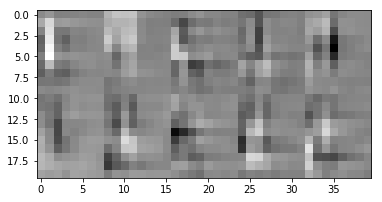

In [20]:
w1_val = np.load('model/w1.npy')
print('w1_val.shape =', w1_val.shape)
h = w1_val.shape[0]
w = w1_val.shape[1]
wi_image = np.zeros([h*5, w*2])
for i in range(5):
    for j in range(2):
        wi_image[i*h:(i+1)*h, j*w:(j+1)*w] = w1_val[:, :, 0, 2*i+j]
        print('max', np.max(w1_val[:, :, 0, 2*i+j]), 'min', np.min(w1_val[:, :, 0, 2*i+j]))
plt.imshow(np.transpose(wi_image), cmap='gray')

### Build the Predict Layer

In [23]:
def get_predict_layer(batch_size):
    
    g = tf.Graph()
    with g.as_default():
        
        # %%
        # input to the network
        input_shape = [batch_size, 40, 320, 1]
        x1 = tf.placeholder(tf.float32, input_shape, name='x1')
        x2 = tf.placeholder(tf.float32, input_shape, name='x2')
       
        # %%
        # Build the encoder
#         n_filters = [1, 20]
#         filter_sizes = [[8, 10]]
#         strides = [[4, 5]]
        w1_val = np.load('model/w1.npy')
        w1 = tf.constant(w1_val)
        b1_val = np.load('model/b1.npy')
        b1 = tf.constant(b1_val)
        Code_layer_1_t1 = tf.nn.relu(tf.add(tf.nn.conv2d(x1, w1, strides=[1, 4, 5, 1], padding='VALID'), b1))
        Code_layer_1_t2 = tf.nn.relu(tf.add(tf.nn.conv2d(x2, w1, strides=[1, 4, 5, 1], padding='VALID'), b1))
        print('Code_layer_1_t1 has output shape =', Code_layer_1_t1.get_shape())
        print('Code_layer_1_t2 has output shape =', Code_layer_1_t2.get_shape())
        
        # %%
        # Build head cells
        n_input = 10
        n_output = 40
        w2 = tf.Variable(tf.random_uniform([3, 3, n_input, n_output], -1.0 / math.sqrt(n_input), 1.0 / math.sqrt(n_input)))
        b2 = tf.Variable(tf.zeros([n_output]))
        head_layer_1_t1 = tf.nn.relu(tf.add(tf.nn.conv2d(Code_layer_1_t1, w2, strides=[1, 3, 3, 1], padding='VALID'), b2))
        shape = Code_layer_1_t1.get_shape()
        print('head_layer_1_t1 has output shape =', head_layer_1_t1.get_shape())
        
#         head_layer_1_t2 = tf.nn.relu(tf.add(tf.nn.conv2d(Code_layer_1_t2, w2, strides=[1, 3, 3, 1], padding='VALID'), b2))
#         print('head_layer_1_t2 has output shape =', head_layer_1_t2.get_shape())
        # %%
        # predict Code_layer_1_t2 using head_layer_1_t1
        b2_2 = tf.Variable(tf.zeros([n_input]))
        Code_layer_1_t2_H = tf.nn.relu(
                tf.add(
                tf.nn.conv2d_transpose(head_layer_1_t1, w2, tf.stack([batch_size, shape[1], shape[2], shape[3]]),
                                       strides=[1, 3, 3, 1], padding='VALID'),
                       b2_2))
        print('Code_layer_1_t2_H has output shape =', Code_layer_1_t2_H.get_shape())
        # %%
        # cost function measures pixel-wise difference
        cost1 = tf.reduce_sum(tf.square(Code_layer_1_t2_H - Code_layer_1_t2))
        
        # %%
        # Build place cells
        n_output = 30
        w3 = tf.Variable(tf.random_uniform([3, 3, n_input, n_output], -1.0 / math.sqrt(n_input), 1.0 / math.sqrt(n_input)))
        b3 = tf.Variable(tf.zeros([n_output]))
        place_layer_1_t1 = tf.nn.relu(tf.add(tf.nn.conv2d(Code_layer_1_t1, w3, strides=[1, 3, 3, 1], padding='VALID'), b3))
        shape = Code_layer_1_t1.get_shape()
        print('place_layer_1_t1 has output shape =', place_layer_1_t1.get_shape())
        
#         place_layer_1_t2 = lrelu(tf.add(tf.nn.conv2d(Code_layer_1_t2, w3, strides=[1, 3, 3, 1], padding='VALID'), b3))
#         print('place_layer_1_t2 has output shape =', place_layer_1_t2.get_shape())
        # %%
        # predict Code_layer_1_t2 using head_layer_1_t1
        b3_2 = tf.Variable(tf.zeros([n_input]))
        Code_layer_1_t2_P = tf.nn.relu(
                tf.add(
                tf.nn.conv2d_transpose(place_layer_1_t1, w3, tf.stack([batch_size, shape[1], shape[2], shape[3]]),
                                       strides=[1, 3, 3, 1], padding='VALID'),
                       b3_2))
        print('Code_layer_1_t2_P has output shape =', Code_layer_1_t2_P.get_shape())
        # %%
        # cost function measures pixel-wise difference
        cost2 = tf.reduce_sum(tf.square(Code_layer_1_t2_P - Code_layer_1_t2))

#         steps = tf.placeholder(tf.float32, [batch_size], name='steps')
#         angles = tf.placeholder(tf.float32, [batch_size], name='angles')

        # %%
        # define the optimizer
        learning_rate = 0.001
        optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(cost1, var_list=[w2, b2, b2_2])
        optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(cost2, var_list=[w3, b3, b3_2])
        
        # %%
        # dict for inputs, outputs, and costs
        pred = {'x1': x1, 'x2': x2, 'cost1': cost1, 'cost2': cost2, 'head_layer_1_t1':head_layer_1_t1, 'place_layer_1_t1': place_layer_1_t1, 'optimizer1':optimizer1, 'optimizer2':optimizer2}
        
        return g, pred

In [24]:
saved_model = 'modelxxx3'

# %%
# Fit training data
example_num = 1
tf.reset_default_graph()
g, ae = get_predict_layer(example_num)
with g.as_default():
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(ae['optimizer1'], feed_dict={ae['x1']: train1, ae['x2']: train2})
            if train_angle != 0:
                sess.run(ae['optimizer2'], feed_dict={ae['x1']: train1, ae['x2']: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([ae['cost1'], ae['cost2']], feed_dict={ae['x1']: train1, ae['x2']: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(ae['optimizer1'], feed_dict={ae['x1']: train1, ae['x2']: train2})
            if train_angle != 0:
                sess.run(ae['optimizer2'], feed_dict={ae['x1']: train1, ae['x2']: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([ae['cost1'], ae['cost2']], feed_dict={ae['x1']: train1, ae['x2']: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

Code_layer_1_t1 has output shape = (1, 9, 63, 10)
Code_layer_1_t2 has output shape = (1, 9, 63, 10)
head_layer_1_t1 has output shape = (1, 3, 21, 40)
Code_layer_1_t2_H has output shape = (1, 9, 63, 10)
place_layer_1_t1 has output shape = (1, 3, 21, 30)
Code_layer_1_t2_P has output shape = (1, 9, 63, 10)
0 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 8181.53 cost2 = 3407.47
0 : 10000 step =  0.0 angle = -10.0 :1:cost1 = 629.861 cost2 = 81.963
0 : 20000 step =  0.0 angle = 9.99999999998 :1:cost1 = 701.259 cost2 = 147.343
0 : 30000 step =  0.0 angle = -10.0 :1:cost1 = 612.732 cost2 = 124.474
0 : 0 step =  0.0 angle = 9.99999999998 :1:cost1 = 366.785 cost2 = 143.216
0 : 10000 step =  0.0 angle = 10.0 :1:cost1 = 373.345 cost2 = 140.313
0 : 20000 step =  0.0 angle = -9.99999999997 :1:cost1 = 294.628 cost2 = 106.094
0 : 30000 step =  0.0 angle = 10.0 :1:cost1 = 290.964 cost2 = 98.5742
1 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 219.895 cost2 = 56.0902
1 : 10000 step =  0.0 angle = 

# Head and Place Cells Test

In [ ]:
# load test data
test_images = np.load('test_images.npy')
print(test_images.shape)
# test_mean_img = np.mean(test_images, axis=0)
# print('test_mean_img.shape =', test_mean_img.shape)
# plt.imshow(test_mean_img[:, :, 0], cmap='gray')

test_cmds = np.load('test_cmds.npy')
print(test_cmds.shape)
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
print(test_xs.shape, len(test_x_set))
# print(test_x_set)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
print(test_ys.shape, len(test_y_set))
# print(test_y_set)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
print(test_angles.shape, len(test_angle_set))
# print(test_angle_set)

In [17]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

example_num = 1
batch_size = example_num 
tf.reset_default_graph()
g, ae = get_predict_layer(example_num)
with g.as_default():
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    for idx in range(test_images.shape[0]):
        batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    #     test_image = np.array([img - test_mean_img for img in batch_xs])
        test_image = batch_xs
        test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
        test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
        test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
        Head_val, Place_val = sess.run([ae['head_layer_1_t1'], ae['place_layer_1_t1']], feed_dict={ae['x1']: test_image})
        print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
        for idx2 in range(batch_size):
            head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
            place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]

Code_layer_1_t1 has output shape = (1, 9, 63, 20)
Code_layer_1_t2 has output shape = (1, 9, 63, 20)
head_layer_1_t1 has output shape = (1, 3, 21, 40)
Code_layer_1_t2_H has output shape = (1, 9, 63, 20)
place_layer_1_t1 has output shape = (1, 3, 21, 30)
Code_layer_1_t2_P has output shape = (1, 9, 63, 20)
INFO:tensorflow:Restoring parameters from model/modelxxx3
0 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9 Head_val.shape = (1, 3, 21, 40) 

150 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
151 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
152 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
153 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
154 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
155 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
156 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
157 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
158 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
159 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
160 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
161 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
162 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
163 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
164 Head_val.shape = (1, 3, 21, 40

306 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
307 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
308 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
309 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
310 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
311 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
312 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
313 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
314 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
315 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
316 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
317 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
318 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
319 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
320 Head_val.shape = (1, 3, 21, 40

479 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
480 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
481 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
482 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
483 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
484 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
485 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
486 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
487 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
488 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
489 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
490 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
491 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
492 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
493 Head_val.shape = (1, 3, 21, 40

652 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
653 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
654 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
655 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
656 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
657 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
658 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
659 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
660 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
661 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
662 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
663 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
664 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
665 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
666 Head_val.shape = (1, 3, 21, 40

810 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
811 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
812 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
813 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
814 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
815 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
816 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
817 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
818 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
819 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
820 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
821 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
822 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
823 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
824 Head_val.shape = (1, 3, 21, 40

966 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
967 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
968 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
969 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
970 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
971 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
972 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
973 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
974 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
975 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
976 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
977 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
978 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
979 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
980 Head_val.shape = (1, 3, 21, 40

1134 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1135 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1136 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1137 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1138 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1139 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1140 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1141 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1142 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1143 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1144 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1145 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1146 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1147 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1148 Head_val.shape 

1304 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1305 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1306 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1307 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1308 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1309 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1310 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1311 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1312 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1313 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1314 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1315 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1316 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1317 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1318 Head_val.shape 

1443 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1444 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1445 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1446 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1447 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1448 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1449 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1450 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1451 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1452 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1453 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1454 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1455 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1456 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1457 Head_val.shape 

1593 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1594 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1595 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1596 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1597 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1598 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1599 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1600 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1601 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1602 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1603 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1604 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1605 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1606 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1607 Head_val.shape 

1715 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1716 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1717 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1718 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1719 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1720 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1721 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1722 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1723 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1724 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1725 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1726 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1727 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1728 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1729 Head_val.shape 

1836 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1837 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1838 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1839 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1840 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1841 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1842 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1843 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1844 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1845 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1846 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1847 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1848 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1849 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1850 Head_val.shape 

1968 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1969 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1970 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1971 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1972 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1973 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1974 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1975 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1976 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1977 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1978 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1979 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1980 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1981 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
1982 Head_val.shape 

2097 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2098 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2099 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2100 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2101 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2102 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2103 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2104 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2105 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2106 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2107 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2108 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2109 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2110 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2111 Head_val.shape 

2235 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2236 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2237 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2238 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2239 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2240 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2241 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2242 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2243 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2244 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2245 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2246 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2247 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2248 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2249 Head_val.shape 

2383 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2384 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2385 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2386 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2387 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2388 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2389 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2390 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2391 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2392 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2393 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2394 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2395 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2396 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2397 Head_val.shape 

2522 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2523 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2524 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2525 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2526 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2527 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2528 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2529 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2530 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2531 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2532 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2533 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2534 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2535 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2536 Head_val.shape 

2682 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2683 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2684 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2685 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2686 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2687 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2688 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2689 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2690 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2691 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2692 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2693 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2694 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2695 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2696 Head_val.shape 

2847 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2848 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2849 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2850 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2851 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2852 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2853 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2854 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2855 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2856 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2857 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2858 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2859 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2860 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2861 Head_val.shape 

2987 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2988 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2989 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2990 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2991 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2992 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2993 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2994 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2995 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2996 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2997 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2998 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
2999 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3000 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3001 Head_val.shape 

3114 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3115 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3116 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3117 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3118 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3119 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3120 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3121 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3122 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3123 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3124 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3125 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3126 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3127 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3128 Head_val.shape 

3241 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3242 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3243 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3244 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3245 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3246 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3247 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3248 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3249 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3250 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3251 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3252 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3253 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3254 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3255 Head_val.shape 

3394 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3395 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3396 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3397 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3398 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3399 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3400 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3401 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3402 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3403 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3404 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3405 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3406 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3407 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3408 Head_val.shape 

3553 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3554 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3555 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3556 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3557 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3558 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3559 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3560 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3561 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3562 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3563 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3564 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3565 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3566 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3567 Head_val.shape 

3720 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3721 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3722 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3723 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3724 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3725 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3726 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3727 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3728 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3729 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3730 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3731 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3732 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3733 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3734 Head_val.shape 

3894 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3895 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3896 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3897 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3898 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3899 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3900 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3901 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3902 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3903 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3904 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3905 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3906 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3907 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
3908 Head_val.shape 

4075 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4076 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4077 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4078 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4079 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4080 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4081 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4082 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4083 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4084 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4085 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4086 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4087 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4088 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4089 Head_val.shape 

4243 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4244 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4245 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4246 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4247 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4248 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4249 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4250 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4251 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4252 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4253 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4254 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4255 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4256 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4257 Head_val.shape 

4420 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4421 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4422 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4423 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4424 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4425 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4426 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4427 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4428 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4429 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4430 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4431 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4432 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4433 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4434 Head_val.shape 

4595 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4596 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4597 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4598 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4599 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4600 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4601 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4602 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4603 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4604 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4605 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4606 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4607 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4608 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4609 Head_val.shape 

4767 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4768 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4769 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4770 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4771 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4772 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4773 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4774 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4775 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4776 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4777 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4778 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4779 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4780 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4781 Head_val.shape 

4940 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4941 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4942 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4943 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4944 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4945 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4946 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4947 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4948 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4949 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4950 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4951 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4952 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4953 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
4954 Head_val.shape 

5118 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5119 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5120 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5121 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5122 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5123 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5124 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5125 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5126 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5127 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5128 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5129 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5130 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5131 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5132 Head_val.shape 

5293 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5294 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5295 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5296 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5297 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5298 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5299 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5300 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5301 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5302 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5303 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5304 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5305 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5306 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5307 Head_val.shape 

5462 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5463 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5464 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5465 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5466 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5467 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5468 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5469 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5470 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5471 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5472 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5473 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5474 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5475 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5476 Head_val.shape 

5634 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5635 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5636 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5637 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5638 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5639 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5640 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5641 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5642 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5643 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5644 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5645 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5646 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5647 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5648 Head_val.shape 

5796 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5797 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5798 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5799 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5800 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5801 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5802 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5803 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5804 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5805 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5806 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5807 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5808 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5809 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5810 Head_val.shape 

5972 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5973 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5974 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5975 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5976 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5977 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5978 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5979 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5980 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5981 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5982 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5983 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5984 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5985 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
5986 Head_val.shape 

6147 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6148 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6149 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6150 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6151 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6152 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6153 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6154 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6155 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6156 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6157 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6158 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6159 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6160 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6161 Head_val.shape 

6320 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6321 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6322 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6323 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6324 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6325 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6326 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6327 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6328 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6329 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6330 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6331 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6332 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6333 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6334 Head_val.shape 

6496 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6497 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6498 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6499 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6500 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6501 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6502 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6503 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6504 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6505 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6506 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6507 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6508 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6509 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6510 Head_val.shape 

6671 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6672 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6673 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6674 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6675 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6676 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6677 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6678 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6679 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6680 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6681 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6682 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6683 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6684 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6685 Head_val.shape 

6847 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6848 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6849 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6850 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6851 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6852 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6853 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6854 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6855 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6856 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6857 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6858 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6859 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6860 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
6861 Head_val.shape 

7019 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7020 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7021 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7022 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7023 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7024 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7025 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7026 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7027 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7028 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7029 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7030 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7031 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7032 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7033 Head_val.shape 

7198 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7199 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7200 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7201 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7202 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7203 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7204 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7205 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7206 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7207 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7208 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7209 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7210 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7211 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7212 Head_val.shape 

7368 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7369 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7370 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7371 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7372 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7373 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7374 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7375 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7376 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7377 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7378 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7379 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7380 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7381 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7382 Head_val.shape 

7540 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7541 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7542 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7543 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7544 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7545 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7546 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7547 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7548 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7549 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7550 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7551 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7552 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7553 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7554 Head_val.shape 

7716 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7717 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7718 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7719 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7720 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7721 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7722 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7723 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7724 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7725 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7726 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7727 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7728 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7729 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7730 Head_val.shape 

7889 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7890 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7891 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7892 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7893 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7894 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7895 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7896 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7897 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7898 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7899 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7900 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7901 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7902 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
7903 Head_val.shape 

8059 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8060 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8061 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8062 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8063 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8064 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8065 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8066 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8067 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8068 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8069 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8070 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8071 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8072 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8073 Head_val.shape 

8234 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8235 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8236 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8237 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8238 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8239 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8240 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8241 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8242 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8243 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8244 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8245 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8246 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8247 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8248 Head_val.shape 

8401 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8402 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8403 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8404 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8405 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8406 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8407 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8408 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8409 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8410 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8411 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8412 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8413 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8414 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8415 Head_val.shape 

8580 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8581 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8582 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8583 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8584 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8585 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8586 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8587 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8588 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8589 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8590 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8591 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8592 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8593 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8594 Head_val.shape 

8749 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8750 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8751 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8752 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8753 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8754 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8755 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8756 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8757 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8758 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8759 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8760 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8761 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8762 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8763 Head_val.shape 

8925 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8926 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8927 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8928 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8929 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8930 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8931 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8932 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8933 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8934 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8935 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8936 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8937 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8938 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
8939 Head_val.shape 

9104 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9105 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9106 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9107 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9108 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9109 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9110 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9111 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9112 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9113 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9114 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9115 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9116 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9117 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9118 Head_val.shape 

9279 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9280 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9281 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9282 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9283 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9284 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9285 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9286 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9287 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9288 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9289 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9290 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9291 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9292 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9293 Head_val.shape 

9455 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9456 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9457 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9458 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9459 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9460 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9461 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9462 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9463 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9464 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9465 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9466 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9467 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9468 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9469 Head_val.shape 

9625 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9626 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9627 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9628 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9629 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9630 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9631 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9632 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9633 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9634 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9635 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9636 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9637 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9638 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9639 Head_val.shape 

9793 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9794 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9795 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9796 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9797 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9798 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9799 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9800 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9801 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9802 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9803 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9804 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9805 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9806 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9807 Head_val.shape 

9967 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9968 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9969 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9970 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9971 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9972 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9973 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9974 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9975 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9976 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9977 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9978 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9979 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9980 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
9981 Head_val.shape 

10135 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10136 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10137 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10138 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10139 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10140 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10141 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10142 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10143 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10144 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10145 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10146 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10147 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10148 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10149 

10309 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10310 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10311 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10312 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10313 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10314 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10315 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10316 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10317 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10318 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10319 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10320 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10321 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10322 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10323 

10462 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10463 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10464 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10465 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10466 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10467 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10468 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10469 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10470 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10471 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10472 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10473 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10474 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10475 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10476 

10603 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10604 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10605 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10606 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10607 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10608 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10609 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10610 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10611 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10612 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10613 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10614 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10615 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10616 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10617 

10751 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10752 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10753 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10754 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10755 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10756 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10757 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10758 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10759 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10760 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10761 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10762 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10763 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10764 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10765 

10890 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10891 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10892 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10893 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10894 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10895 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10896 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10897 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10898 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10899 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10900 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10901 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10902 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10903 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
10904 

11068 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11069 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11070 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11071 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11072 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11073 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11074 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11075 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11076 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11077 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11078 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11079 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11080 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11081 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11082 

11227 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11228 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11229 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11230 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11231 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11232 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11233 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11234 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11235 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11236 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11237 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11238 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11239 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11240 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11241 

11384 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11385 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11386 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11387 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11388 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11389 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11390 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11391 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11392 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11393 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11394 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11395 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11396 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11397 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11398 

11545 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11546 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11547 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11548 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11549 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11550 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11551 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11552 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11553 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11554 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11555 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11556 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11557 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11558 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11559 

11691 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11692 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11693 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11694 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11695 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11696 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11697 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11698 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11699 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11700 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11701 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11702 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11703 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11704 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11705 

11834 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11835 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11836 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11837 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11838 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11839 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11840 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11841 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11842 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11843 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11844 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11845 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11846 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11847 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
11848 

12004 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12005 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12006 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12007 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12008 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12009 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12010 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12011 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12012 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12013 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12014 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12015 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12016 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12017 Head_val.shape = (1, 3, 21, 40) Place_val.shape = (1, 3, 21, 30)
12018 

In [ ]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

idx_x = int(rnd.random()*(3-1))
idx_y = int(rnd.random()*(21-1))

example_num = 1
batch_size = example_num 
tf.reset_default_graph()
g, ae = get_predict_layer(example_num)
with g.as_default():
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    for idx in range(test_images.shape[0]):
        batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    #     test_image = np.array([img - test_mean_img for img in batch_xs])
        test_image = batch_xs
        test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
        test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
        test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
        Head_val, Place_val = sess.run([ae['head_layer_1_t1'], ae['place_layer_1_t1']], feed_dict={ae['x1']: test_image})
        print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
        for idx2 in range(batch_size):
            head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += Head_val[idx2, idx_x, idx_y, :]
            head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
            place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += Place_val[idx2, idx_x, idx_y, :]

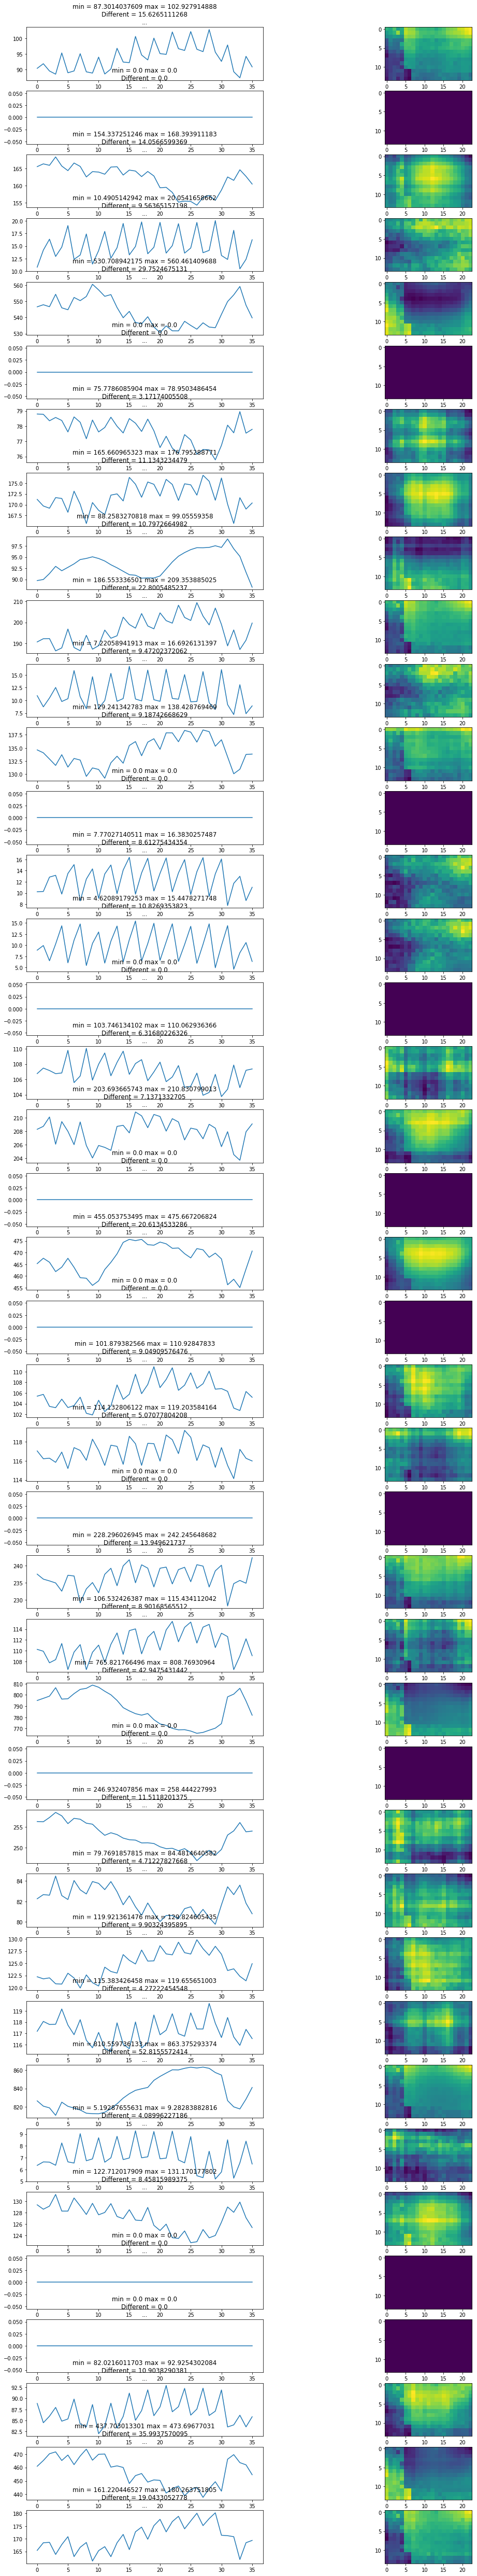

In [39]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
for example_i in range(40):
    axs[example_i][0].plot(np.abs(head_map_4_head_cell[:, example_i]))
    min_val = min(head_map_4_head_cell[:, example_i])
    max_val = max(head_map_4_head_cell[:, example_i])
    axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_head_cell[:, 0:23, example_i]))
plt.show()

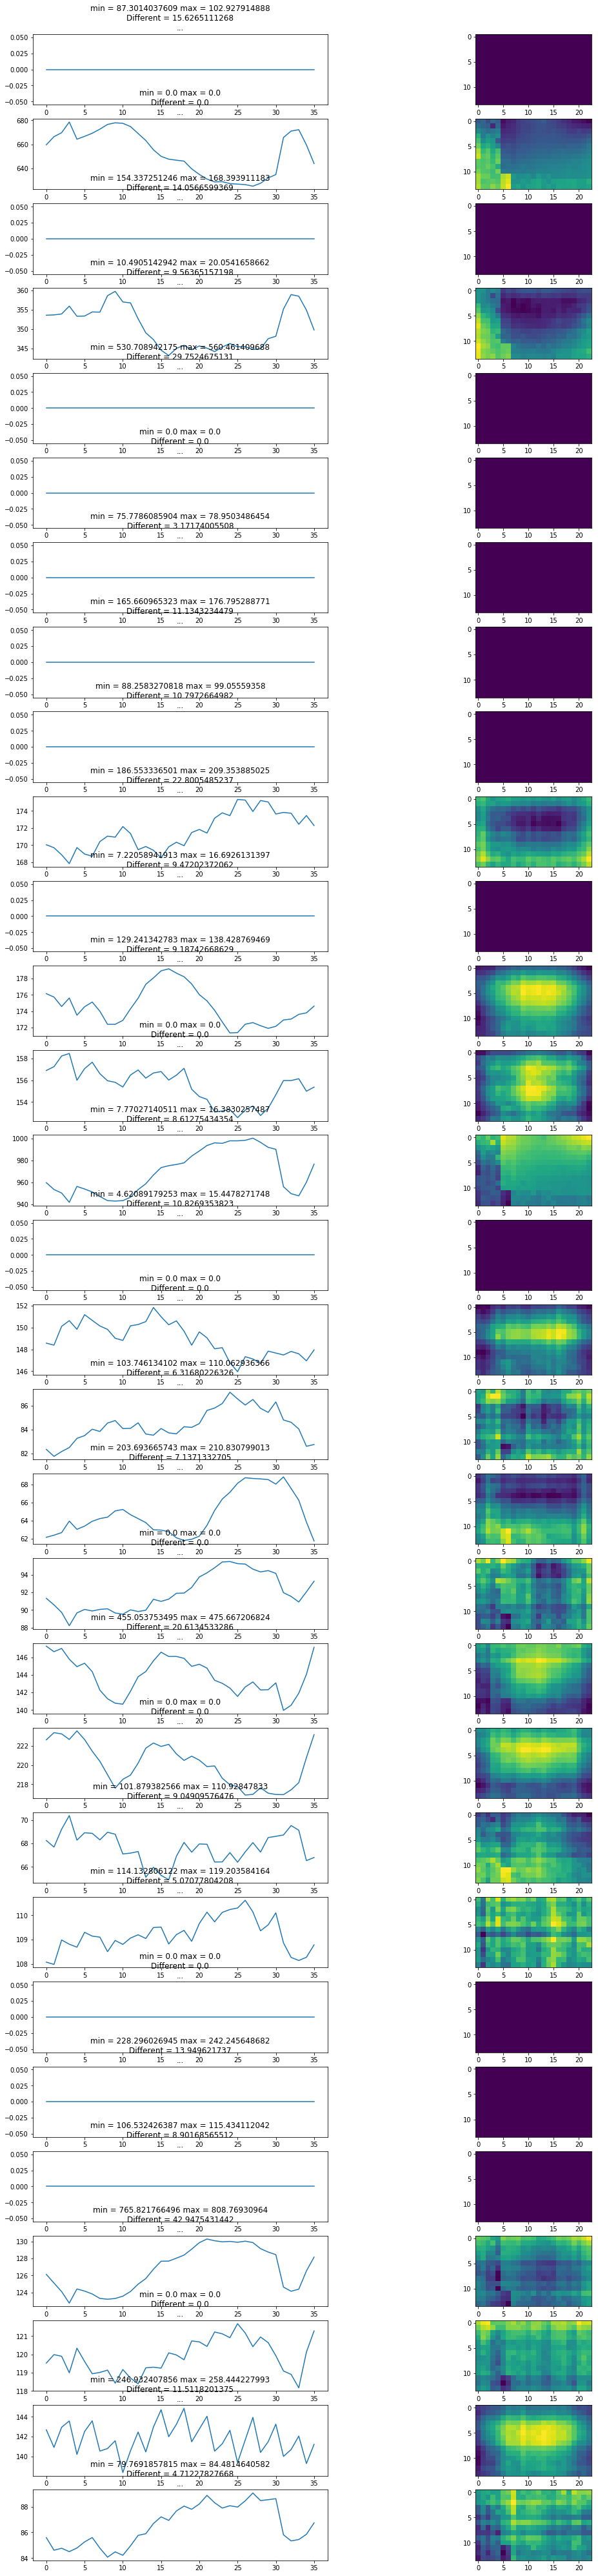

In [40]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
for example_i in range(30):
    axs[example_i][0].plot(np.abs(head_map_4_place_cell[:, example_i]))
    min_val = min(head_map_4_head_cell[:, example_i])
    max_val = max(head_map_4_head_cell[:, example_i])
    axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_place_cell[:, 0:23, example_i]))
plt.show()